In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pyod
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pyod
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.metrics import roc_auc_score,roc_curve,auc

In [2]:
df=pd.read_csv("synthetic_weather_data_wo_label_30anomalyinjected.csv",header=0, index_col=0, parse_dates=True)
df_labeled=pd.read_csv("synthetic_weather_data_wi_label_supervised_30anomalyinjected.csv",header=0, index_col=0, parse_dates=True)

### 1 year test data and 30 anomalies

In [3]:
# Not on same scale and need to split the data to the train and test part 
Ntest = 365   # 1 year
train= df.iloc[:-Ntest].copy()
test= df.iloc[-Ntest:].copy()

scaler_temp= RobustScaler()
train['ScaledTemp'] = scaler_temp.fit_transform(train[['temperature']])
test['ScaledTemp'] = scaler_temp.transform(test[['temperature']])

scaler_humid= RobustScaler()
train['ScaledHumid'] = scaler_humid.fit_transform(train[['humidity']])
test['ScaledHumid'] = scaler_humid.transform(test[['humidity']])

scaler_pressure= RobustScaler()
train['ScaledPressure'] = scaler_pressure.fit_transform(train[['pressure']])
test['ScaledPressure'] = scaler_pressure.transform(test[['pressure']])

train_idx = df.index <=train.index[-1]
test_idx = df.index > train.index[-1]

df.loc[train_idx, 'ScaledTemp']= train['ScaledTemp']
df.loc[test_idx, 'ScaledTemp']= test['ScaledTemp']

df.loc[train_idx, 'ScaledHumid']= train['ScaledHumid']
df.loc[test_idx, 'ScaledHumid']= test['ScaledHumid']

df.loc[train_idx, 'ScaledPressure']= train['ScaledPressure']
df.loc[test_idx, 'ScaledPressure']= test['ScaledPressure']

<AxesSubplot: xlabel='date'>

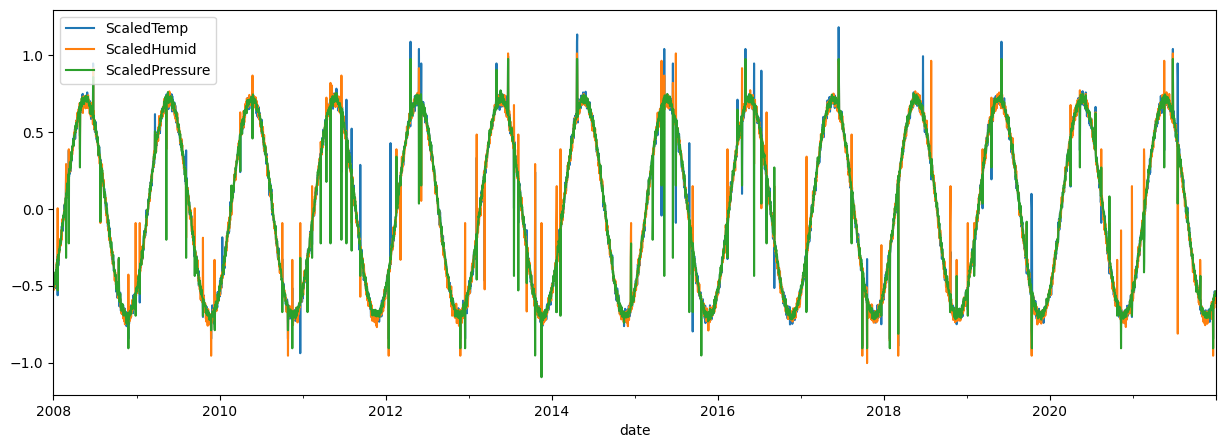

In [4]:
cols = ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']
train[cols].plot(figsize=(15,5))

<AxesSubplot: xlabel='date'>

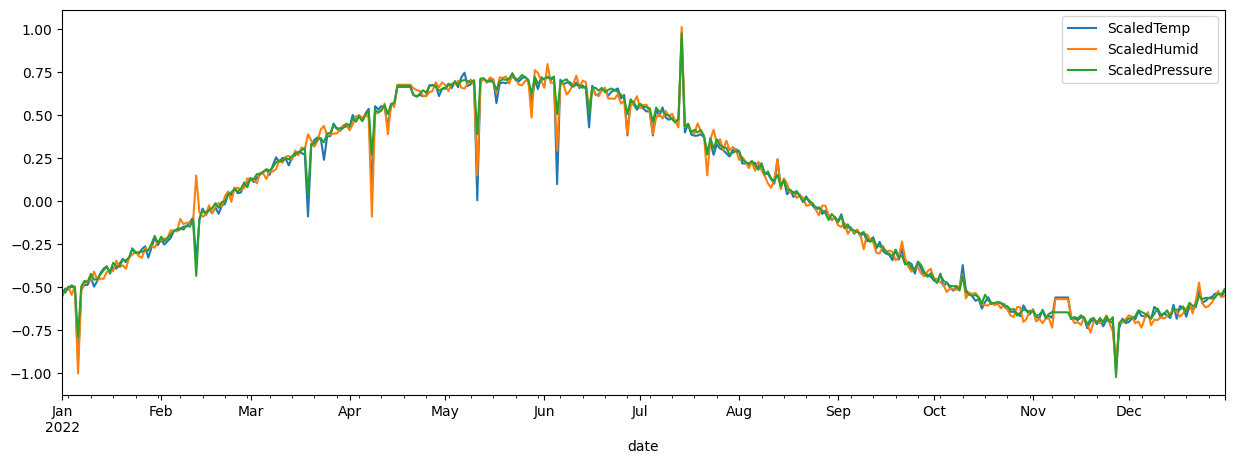

In [5]:
cols = ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']
test[cols].plot(figsize=(15,5))

In [6]:
df_combined=[train[cols],test[cols]]
df_combined=pd.concat(df_combined, axis=0)

In [7]:
for i in range(1, 8):
    df_combined[f'ST_t-{i}'] = df_combined['ScaledTemp'].shift(i)

In [8]:
for i in range(1, 8):
    df_combined[f'SH_t-{i}'] = df_combined['ScaledHumid'].shift(i)

In [9]:
for i in range(1, 8):
    df_combined[f'SP_t-{i}'] = df_combined['ScaledPressure'].shift(i)

In [10]:
df_combined.head()

,ScaledTemp,ScaledHumid,ScaledPressure,ST_t-1,ST_t-2,ST_t-3,ST_t-4,ST_t-5,ST_t-6,ST_t-7,...,SH_t-5,SH_t-6,SH_t-7,SP_t-1,SP_t-2,SP_t-3,SP_t-4,SP_t-5,SP_t-6,SP_t-7
date,,,,,,,,,,,,,,,,,,,,,
2008-01-01,-0.472278,-0.519051,-0.501793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-02,-0.513243,-0.515696,-0.505789,-0.472278,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.501793,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-03,-0.498646,-0.517613,-0.487922,-0.513243,-0.472278,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.505789,-0.501793,NaN,NaN,NaN,NaN,NaN
2008-01-04,-0.500059,-0.526719,-0.508375,-0.498646,-0.513243,-0.472278,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.487922,-0.505789,-0.501793,NaN,NaN,NaN,NaN
2008-01-05,-0.487816,-0.509466,-0.480165,-0.500059,-0.498646,-0.513243,-0.472278,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.508375,-0.487922,-0.505789,-0.501793,NaN,NaN,NaN


In [11]:
df_combined = df_combined.dropna()

In [12]:
df_combined.head()

,ScaledTemp,ScaledHumid,ScaledPressure,ST_t-1,ST_t-2,ST_t-3,ST_t-4,ST_t-5,ST_t-6,ST_t-7,...,SH_t-5,SH_t-6,SH_t-7,SP_t-1,SP_t-2,SP_t-3,SP_t-4,SP_t-5,SP_t-6,SP_t-7
date,,,,,,,,,,,,,,,,,,,,,
2008-01-08,-0.462861,-0.494129,-0.448428,-0.506180,-0.502413,-0.487816,-0.500059,-0.498646,-0.513243,-0.472278,...,-0.517613,-0.515696,-0.519051,-0.484866,-0.493329,-0.480165,-0.508375,-0.487922,-0.505789,-0.501793
2008-01-09,-0.515597,-0.461059,-0.488158,-0.462861,-0.506180,-0.502413,-0.487816,-0.500059,-0.498646,-0.513243,...,-0.526719,-0.517613,-0.515696,-0.448428,-0.484866,-0.493329,-0.480165,-0.508375,-0.487922,-0.505789
2008-01-10,-0.441672,-0.455787,-0.445372,-0.515597,-0.462861,-0.506180,-0.502413,-0.487816,-0.500059,-0.498646,...,-0.509466,-0.526719,-0.517613,-0.488158,-0.448428,-0.484866,-0.493329,-0.480165,-0.508375,-0.487922
2008-01-11,-0.437434,-0.427510,-0.410344,-0.441672,-0.515597,-0.462861,-0.506180,-0.502413,-0.487816,-0.500059,...,-0.486461,-0.509466,-0.526719,-0.445372,-0.488158,-0.448428,-0.484866,-0.493329,-0.480165,-0.508375
2008-01-12,-0.454385,-0.455308,-0.463238,-0.437434,-0.441672,-0.515597,-0.462861,-0.506180,-0.502413,-0.487816,...,-0.505152,-0.486461,-0.509466,-0.410344,-0.445372,-0.488158,-0.448428,-0.484866,-0.493329,-0.480165


In [13]:
df_combined.shape

(5472, 24)

In [14]:
# Not on same scale and need to split the data to the train and test part 
nest_samples = 365  # 1 year
train_data = df_combined.iloc[:-nest_samples].copy()
test_data = df_combined.iloc[-nest_samples:].copy()

In [15]:
train_data.shape

(5107, 24)

In [16]:
test_data.shape

(365, 24)

In [17]:
features = [col for col in df_combined.columns if col not in ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']]
X_train, y_train = train_data[features], train_data[['ScaledTemp', 'ScaledHumid', 'ScaledPressure']] #Split into X and Y. training data.

In [18]:
X_train

,ST_t-1,ST_t-2,ST_t-3,ST_t-4,ST_t-5,ST_t-6,ST_t-7,SH_t-1,SH_t-2,SH_t-3,...,SH_t-5,SH_t-6,SH_t-7,SP_t-1,SP_t-2,SP_t-3,SP_t-4,SP_t-5,SP_t-6,SP_t-7
date,,,,,,,,,,,,,,,,,,,,,
2008-01-08,-0.506180,-0.502413,-0.487816,-0.500059,-0.498646,-0.513243,-0.472278,-0.505152,-0.486461,-0.509466,...,-0.517613,-0.515696,-0.519051,-0.484866,-0.493329,-0.480165,-0.508375,-0.487922,-0.505789,-0.501793
2008-01-09,-0.462861,-0.506180,-0.502413,-0.487816,-0.500059,-0.498646,-0.513243,-0.494129,-0.505152,-0.486461,...,-0.526719,-0.517613,-0.515696,-0.448428,-0.484866,-0.493329,-0.480165,-0.508375,-0.487922,-0.505789
2008-01-10,-0.515597,-0.462861,-0.506180,-0.502413,-0.487816,-0.500059,-0.498646,-0.461059,-0.494129,-0.505152,...,-0.509466,-0.526719,-0.517613,-0.488158,-0.448428,-0.484866,-0.493329,-0.480165,-0.508375,-0.487922
2008-01-11,-0.441672,-0.515597,-0.462861,-0.506180,-0.502413,-0.487816,-0.500059,-0.455787,-0.461059,-0.494129,...,-0.486461,-0.509466,-0.526719,-0.445372,-0.488158,-0.448428,-0.484866,-0.493329,-0.480165,-0.508375
2008-01-12,-0.437434,-0.441672,-0.515597,-0.462861,-0.506180,-0.502413,-0.487816,-0.427510,-0.455787,-0.461059,...,-0.505152,-0.486461,-0.509466,-0.410344,-0.445372,-0.488158,-0.448428,-0.484866,-0.493329,-0.480165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,-0.536315,-0.608829,-0.584815,-0.574926,-0.575397,-0.584344,-0.626251,-0.603403,-0.585191,-0.643662,...,-0.583753,-0.645579,-0.641265,-0.557508,-0.565501,-0.562210,-0.565501,-0.591596,-0.582662,-0.623803
2021-12-28,-0.582931,-0.536315,-0.608829,-0.584815,-0.574926,-0.575397,-0.584344,-0.612030,-0.603403,-0.585191,...,-0.608675,-0.583753,-0.645579,-0.567382,-0.557508,-0.565501,-0.562210,-0.565501,-0.591596,-0.582662
2021-12-29,-0.556092,-0.582931,-0.536315,-0.608829,-0.584815,-0.574926,-0.575397,-0.585670,-0.612030,-0.603403,...,-0.643662,-0.608675,-0.583753,-0.562445,-0.567382,-0.557508,-0.565501,-0.562210,-0.565501,-0.591596


In [19]:
y_train

,ScaledTemp,ScaledHumid,ScaledPressure
date,,,
2008-01-08,-0.462861,-0.494129,-0.448428
2008-01-09,-0.515597,-0.461059,-0.488158
2008-01-10,-0.441672,-0.455787,-0.445372
2008-01-11,-0.437434,-0.427510,-0.410344
2008-01-12,-0.454385,-0.455308,-0.463238
...,...,...,...
2021-12-27,-0.582931,-0.612030,-0.567382
2021-12-28,-0.556092,-0.585670,-0.562445
2021-12-29,-0.598941,-0.540618,-0.565736


In [20]:
x_test, y_test = test_data[features], test_data[['ScaledTemp', 'ScaledHumid', 'ScaledPressure']]

In [21]:
x_test

,ST_t-1,ST_t-2,ST_t-3,ST_t-4,ST_t-5,ST_t-6,ST_t-7,SH_t-1,SH_t-2,SH_t-3,...,SH_t-5,SH_t-6,SH_t-7,SP_t-1,SP_t-2,SP_t-3,SP_t-4,SP_t-5,SP_t-6,SP_t-7
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,-0.567393,-0.560800,-0.598941,-0.556092,-0.582931,-0.536315,-0.608829,-0.548766,-0.585670,-0.540618,...,-0.612030,-0.603403,-0.585191,-0.546459,-0.535880,-0.565736,-0.562445,-0.567382,-0.557508,-0.565501
2022-01-02,-0.557975,-0.567393,-0.560800,-0.598941,-0.556092,-0.582931,-0.536315,-0.541098,-0.548766,-0.585670,...,-0.585670,-0.612030,-0.603403,-0.517543,-0.546459,-0.535880,-0.565736,-0.562445,-0.567382,-0.557508
2022-01-03,-0.509947,-0.557975,-0.567393,-0.560800,-0.598941,-0.556092,-0.582931,-0.531512,-0.541098,-0.548766,...,-0.540618,-0.585670,-0.612030,-0.534234,-0.517543,-0.546459,-0.535880,-0.565736,-0.562445,-0.567382
2022-01-04,-0.515127,-0.509947,-0.557975,-0.567393,-0.560800,-0.598941,-0.556092,-0.499880,-0.531512,-0.541098,...,-0.585670,-0.540618,-0.585670,-0.499207,-0.534234,-0.517543,-0.546459,-0.535880,-0.565736,-0.562445
2022-01-05,-0.491583,-0.515127,-0.509947,-0.557975,-0.567393,-0.560800,-0.598941,-0.546370,-0.499880,-0.531512,...,-0.548766,-0.585670,-0.540618,-0.501557,-0.499207,-0.534234,-0.517543,-0.546459,-0.535880,-0.565736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,-0.565038,-0.582460,-0.592348,-0.515127,-0.615892,-0.629547,-0.613537,-0.612030,-0.620177,-0.595255,...,-0.579919,-0.655164,-0.600048,-0.565031,-0.564326,-0.572554,-0.554217,-0.605701,-0.612048,-0.592771
2022-12-28,-0.558917,-0.565038,-0.582460,-0.592348,-0.515127,-0.615892,-0.629547,-0.591421,-0.612030,-0.620177,...,-0.475917,-0.579919,-0.655164,-0.568557,-0.565031,-0.564326,-0.572554,-0.554217,-0.605701,-0.612048
2022-12-29,-0.540553,-0.558917,-0.565038,-0.582460,-0.592348,-0.515127,-0.615892,-0.563144,-0.591421,-0.612030,...,-0.595255,-0.475917,-0.579919,-0.561505,-0.568557,-0.565031,-0.564326,-0.572554,-0.554217,-0.605701


In [22]:
y_test

,ScaledTemp,ScaledHumid,ScaledPressure
date,,,
2022-01-01,-0.557975,-0.541098,-0.517543
2022-01-02,-0.509947,-0.531512,-0.534234
2022-01-03,-0.515127,-0.499880,-0.499207
2022-01-04,-0.491583,-0.546370,-0.501557
2022-01-05,-0.504297,-0.497005,-0.502968
...,...,...,...
2022-12-27,-0.558917,-0.591421,-0.568557
2022-12-28,-0.540553,-0.563144,-0.561505
2022-12-29,-0.535845,-0.524802,-0.540112


In [23]:
xgb = XGBRegressor()
#n_estimators=100, learning_rate=0.05, random_state=42

In [24]:
models = []
for i in range(3):
    model = xgb
    model.fit(X_train, y_train.iloc[:, i])
    models.append(model)

In [25]:
# Make predictions on the test set for each target variable
y_pred = []
for i in range(3):
    y_pred.append(models[i].predict(x_test))

In [26]:
# Combine the predictions into a single dataframe
df_prediction = pd.DataFrame({'Predicted_temperature': y_pred[0], 'Predicted_humidity': y_pred[1], 'Predicted_pressure': y_pred[2]}, index=x_test.index)

In [27]:
# Make predictions on the test set for each target variable
y_pred_train = []
for i in range(3):
    y_pred_train.append(models[i].predict(X_train))

In [28]:
# Combine the predictions into a single dataframe on training prediction
df_prediction_train = pd.DataFrame({'Predicted_temperature': y_pred_train[0], 'Predicted_humidity': y_pred_train[1], 'Predicted_pressure': y_pred_train[2]}, index=X_train.index)

In [29]:
df_prediction.shape

(365, 3)

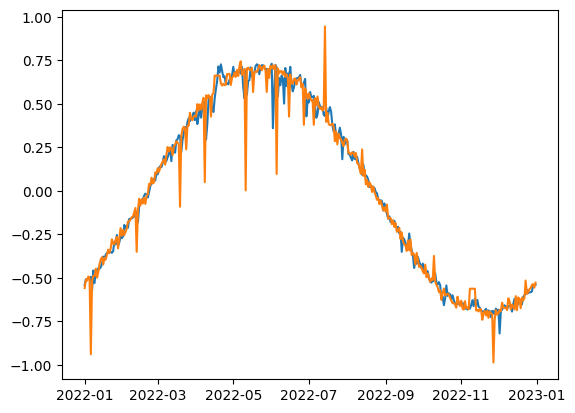

In [30]:
import matplotlib.pyplot as plt
plt.plot(df_prediction['Predicted_temperature'])
plt.plot(y_test['ScaledTemp'])

### data preparation for kNN(actual+predicted+reidual)

In [31]:
#test_data
data_temp_test = pd.DataFrame({'predicted_temp': df_prediction['Predicted_temperature'], 'actual_temp': y_test['ScaledTemp'], 'residual_temp':(y_test['ScaledTemp'] - df_prediction['Predicted_temperature'])})
data_humidity_test = pd.DataFrame({'predicted_humid': df_prediction['Predicted_humidity'], 'actual_humid': y_test['ScaledHumid'], 'residual_humid':(y_test['ScaledHumid'] - df_prediction['Predicted_humidity'])})
data_pressure_test = pd.DataFrame({'predicted_pressure': df_prediction['Predicted_pressure'], 'actual_pressure': y_test['ScaledPressure'], 'residual_pressure':(y_test['ScaledPressure'] - df_prediction['Predicted_pressure'])})
data_kNN_test=pd.concat([data_temp_test,data_humidity_test,data_pressure_test],axis=1)

In [32]:
nest_samples=365
le = LabelEncoder()

ground_truth = df_labeled.iloc[:, -1].values
ground_truth_train = ground_truth[:-nest_samples].copy()
ground_truth_test = ground_truth[-nest_samples:].copy()

ground_truth_train = le.fit_transform(ground_truth_train)
ground_truth_test = le.transform(ground_truth_test)

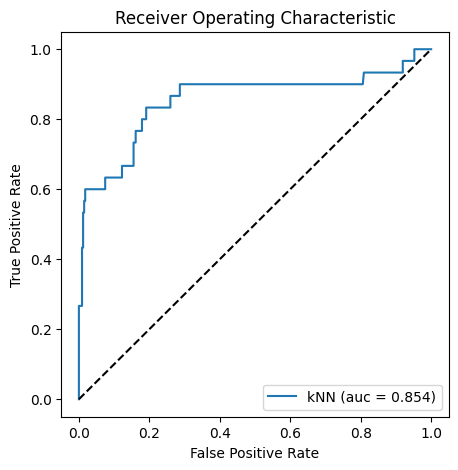


On Test Data:
KNN ROC:0.8541, precision @ rank n:0.6

Outlier prediction information on Test Data: 365 {0: 334, 1: 31}
No of Errors in test set: 25

RMS on Test Set : 0.2617119612951068

MAE on Test Set : 0.0684931506849315


array([[322,  13],
       [ 12,  18]], dtype=int64)

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pyod
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.metrics import roc_auc_score,roc_curve,auc

classifier_name = 'KNN'
# model_knn = KNN()  # with default parameters.
model_knn = KNN()

# Prediction on training data
model_knn.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction = model_knn.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_scores = model_knn.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction = model_knn.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_scores = model_knn.predict_proba(data_kNN_test)[:,1]
# Calculate AUC-ROC score
auc_roc = roc_auc_score(ground_truth_test, test_prediction_scores)
fpr, tpr, thresholds = roc_curve(ground_truth_test, test_prediction_scores)
auc_kNN = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle='-', label='kNN (auc = %0.3f)' % auc_kNN)

#plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], 'k--')  # Random ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print("\nOn Test Data:")
evaluate_print(classifier_name, ground_truth_test, test_prediction_scores)
unique, counts = np.unique(test_prediction, return_counts=True)
print("\nOutlier prediction information on Test Data:", len(data_kNN_test), dict(zip(unique, counts)))
# no of errors in test set
number_of_errors = (test_prediction != ground_truth_test).sum()
print('No of Errors in test set: {}'.format(number_of_errors))
rms = mean_squared_error(ground_truth_test, test_prediction, squared=False)
mae = mean_absolute_error(ground_truth_test, test_prediction)
print('\nRMS on Test Set :',rms)
print('\nMAE on Test Set :',mae)

from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, model_knn.predict(data_kNN_test))

### data for kNN(actual+Predicted)

In [34]:
#test_data
data_temp_aptest = pd.DataFrame({'predicted_temp': df_prediction['Predicted_temperature'], 'actual_temp': y_test['ScaledTemp']})
data_humidity_aptest = pd.DataFrame({'predicted_humid': df_prediction['Predicted_humidity'], 'actual_humid': y_test['ScaledHumid']})
data_pressure_aptest = pd.DataFrame({'predicted_pressure': df_prediction['Predicted_pressure'], 'actual_pressure': y_test['ScaledPressure']})
data_kNN_aptest=pd.concat([data_temp_aptest,data_humidity_aptest,data_pressure_aptest],axis=1)

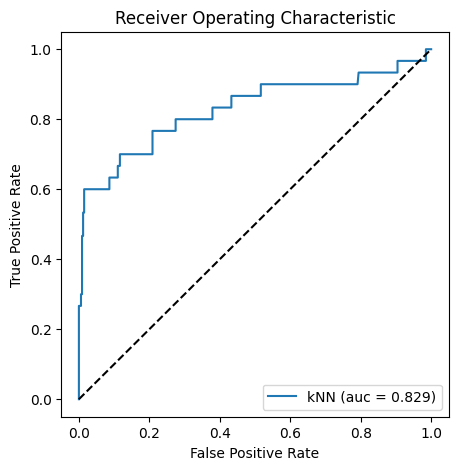


On Test Data:
KNN ROC:0.8293, precision @ rank n:0.6

Outlier prediction information on Test Data: 365 {0: 335, 1: 30}
No of Errors in test set: 24

RMS on Test Set : 0.25642430590241294

MAE on Test Set : 0.06575342465753424


array([[323,  12],
       [ 12,  18]], dtype=int64)

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pyod
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.metrics import roc_auc_score,roc_curve,auc

classifier_name = 'KNN'
# model_knn = KNN()  # with default parameters.
model_knn = KNN()

# Prediction on training data
model_knn.fit(data_kNN_aptest, y=None)  # y is ignored in unsupervised setting.
train_prediction = model_knn.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_scores = model_knn.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction = model_knn.predict(data_kNN_aptest) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_scores = model_knn.predict_proba(data_kNN_aptest)[:,1]
# Calculate AUC-ROC score
auc_roc = roc_auc_score(ground_truth_test, test_prediction_scores)
fpr, tpr, thresholds = roc_curve(ground_truth_test, test_prediction_scores)
auc_kNN = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle='-', label='kNN (auc = %0.3f)' % auc_kNN)

#plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], 'k--')  # Random ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print("\nOn Test Data:")
evaluate_print(classifier_name, ground_truth_test, test_prediction_scores)
unique, counts = np.unique(test_prediction, return_counts=True)
print("\nOutlier prediction information on Test Data:", len(data_kNN_aptest), dict(zip(unique, counts)))
# no of errors in test set
number_of_errors = (test_prediction != ground_truth_test).sum()
print('No of Errors in test set: {}'.format(number_of_errors))
rms = mean_squared_error(ground_truth_test, test_prediction, squared=False)
mae = mean_absolute_error(ground_truth_test, test_prediction)
print('\nRMS on Test Set :',rms)
print('\nMAE on Test Set :',mae)

from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, model_knn.predict(data_kNN_aptest))

### data for kNN(Predicted+residual)

In [36]:
#test_data
data_temp_rtest = pd.DataFrame({'predicted_temp': df_prediction['Predicted_temperature'], 'residual_temp':(y_test['ScaledTemp'] - df_prediction['Predicted_temperature'])})
data_humidity_rtest = pd.DataFrame({'predicted_humid': df_prediction['Predicted_humidity'], 'residual_humid':(y_test['ScaledHumid'] - df_prediction['Predicted_humidity'])})
data_pressure_rtest = pd.DataFrame({'predicted_pressure': df_prediction['Predicted_pressure'], 'residual_pressure':(y_test['ScaledPressure'] - df_prediction['Predicted_pressure'])})
data_kNN_rtest=pd.concat([data_temp_rtest,data_humidity_rtest,data_pressure_rtest],axis=1)

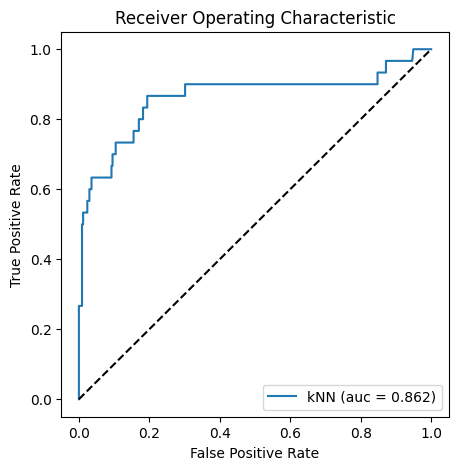


On Test Data:
KNN ROC:0.8624, precision @ rank n:0.6

Outlier prediction information on Test Data: 365 {0: 336, 1: 29}
No of Errors in test set: 23

RMS on Test Set : 0.2510252948014144

MAE on Test Set : 0.06301369863013699


array([[324,  11],
       [ 12,  18]], dtype=int64)

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pyod
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.metrics import roc_auc_score,roc_curve,auc

classifier_name = 'KNN'
# model_knn = KNN()  # with default parameters.
model_knn = KNN()

# Prediction on training data
model_knn.fit(data_kNN_rtest, y=None)  # y is ignored in unsupervised setting.
train_prediction = model_knn.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_scores = model_knn.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction = model_knn.predict(data_kNN_rtest) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_scores = model_knn.predict_proba(data_kNN_rtest)[:,1]
# Calculate AUC-ROC score
auc_roc = roc_auc_score(ground_truth_test, test_prediction_scores)
fpr, tpr, thresholds = roc_curve(ground_truth_test, test_prediction_scores)
auc_kNN = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle='-', label='kNN (auc = %0.3f)' % auc_kNN)

#plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], 'k--')  # Random ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print("\nOn Test Data:")
evaluate_print(classifier_name, ground_truth_test, test_prediction_scores)
unique, counts = np.unique(test_prediction, return_counts=True)
print("\nOutlier prediction information on Test Data:", len(data_kNN_rtest), dict(zip(unique, counts)))
# no of errors in test set
number_of_errors = (test_prediction != ground_truth_test).sum()
print('No of Errors in test set: {}'.format(number_of_errors))
rms = mean_squared_error(ground_truth_test, test_prediction, squared=False)
mae = mean_absolute_error(ground_truth_test, test_prediction)
print('\nRMS on Test Set :',rms)
print('\nMAE on Test Set :',mae)

from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, model_knn.predict(data_kNN_rtest))

In [38]:
# OBSERVATION: actual+Predicted+residual normally is working well.

### 3 year test data 

In [39]:
# Not on same scale and need to split the data to the train and test part 
Ntest = 1096   # 3 year
train= df.iloc[:-Ntest].copy()
test= df.iloc[-Ntest:].copy()

scaler_temp= RobustScaler()
train['ScaledTemp'] = scaler_temp.fit_transform(train[['temperature']])
test['ScaledTemp'] = scaler_temp.transform(test[['temperature']])

scaler_humid= RobustScaler()
train['ScaledHumid'] = scaler_humid.fit_transform(train[['humidity']])
test['ScaledHumid'] = scaler_humid.transform(test[['humidity']])

scaler_pressure= RobustScaler()
train['ScaledPressure'] = scaler_pressure.fit_transform(train[['pressure']])
test['ScaledPressure'] = scaler_pressure.transform(test[['pressure']])

train_idx = df.index <=train.index[-1]
test_idx = df.index > train.index[-1]

df.loc[train_idx, 'ScaledTemp']= train['ScaledTemp']
df.loc[test_idx, 'ScaledTemp']= test['ScaledTemp']

df.loc[train_idx, 'ScaledHumid']= train['ScaledHumid']
df.loc[test_idx, 'ScaledHumid']= test['ScaledHumid']

df.loc[train_idx, 'ScaledPressure']= train['ScaledPressure']
df.loc[test_idx, 'ScaledPressure']= test['ScaledPressure']

<AxesSubplot: xlabel='date'>

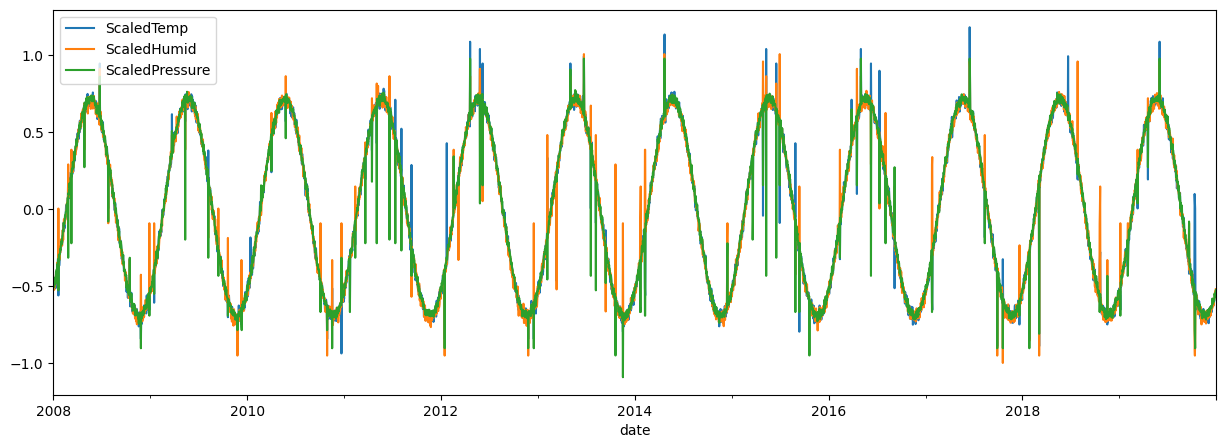

In [40]:
cols = ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']
train[cols].plot(figsize=(15,5))

<AxesSubplot: xlabel='date'>

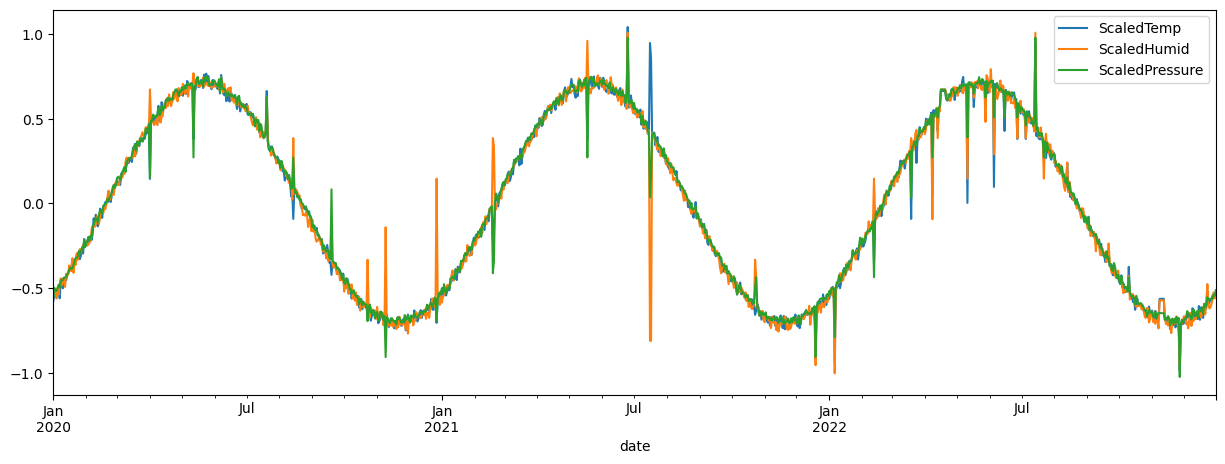

In [41]:
cols = ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']
test[cols].plot(figsize=(15,5))

In [42]:
df_combined=[train[cols],test[cols]]
df_combined=pd.concat(df_combined, axis=0)

In [43]:
for i in range(1, 8):
    df_combined[f'ST_t-{i}'] = df_combined['ScaledTemp'].shift(i)

In [44]:
for i in range(1, 8):
    df_combined[f'SH_t-{i}'] = df_combined['ScaledHumid'].shift(i)

In [45]:
for i in range(1, 8):
    df_combined[f'SP_t-{i}'] = df_combined['ScaledPressure'].shift(i)

In [46]:
df_combined.head()

,ScaledTemp,ScaledHumid,ScaledPressure,ST_t-1,ST_t-2,ST_t-3,ST_t-4,ST_t-5,ST_t-6,ST_t-7,...,SH_t-5,SH_t-6,SH_t-7,SP_t-1,SP_t-2,SP_t-3,SP_t-4,SP_t-5,SP_t-6,SP_t-7
date,,,,,,,,,,,,,,,,,,,,,
2008-01-01,-0.472419,-0.518412,-0.500118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-02,-0.513437,-0.515065,-0.504121,-0.472419,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.500118,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-03,-0.498821,-0.516978,-0.486226,-0.513437,-0.472419,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.504121,-0.500118,NaN,NaN,NaN,NaN,NaN
2008-01-04,-0.500236,-0.526064,-0.506711,-0.498821,-0.513437,-0.472419,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.486226,-0.504121,-0.500118,NaN,NaN,NaN,NaN
2008-01-05,-0.487977,-0.508847,-0.478455,-0.500236,-0.498821,-0.513437,-0.472419,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.506711,-0.486226,-0.504121,-0.500118,NaN,NaN,NaN


In [47]:
df_combined = df_combined.dropna()

In [48]:
df_combined.head()

,ScaledTemp,ScaledHumid,ScaledPressure,ST_t-1,ST_t-2,ST_t-3,ST_t-4,ST_t-5,ST_t-6,ST_t-7,...,SH_t-5,SH_t-6,SH_t-7,SP_t-1,SP_t-2,SP_t-3,SP_t-4,SP_t-5,SP_t-6,SP_t-7
date,,,,,,,,,,,,,,,,,,,,,
2008-01-08,-0.462989,-0.493544,-0.446668,-0.506365,-0.502593,-0.487977,-0.500236,-0.498821,-0.513437,-0.472419,...,-0.516978,-0.515065,-0.518412,-0.483165,-0.491641,-0.478455,-0.506711,-0.486226,-0.504121,-0.500118
2008-01-09,-0.515794,-0.460545,-0.486461,-0.462989,-0.506365,-0.502593,-0.487977,-0.500236,-0.498821,-0.513437,...,-0.526064,-0.516978,-0.515065,-0.446668,-0.483165,-0.491641,-0.478455,-0.506711,-0.486226,-0.504121
2008-01-10,-0.441773,-0.455285,-0.443607,-0.515794,-0.462989,-0.506365,-0.502593,-0.487977,-0.500236,-0.498821,...,-0.508847,-0.526064,-0.516978,-0.486461,-0.446668,-0.483165,-0.491641,-0.478455,-0.506711,-0.486226
2008-01-11,-0.437529,-0.427068,-0.408524,-0.441773,-0.515794,-0.462989,-0.506365,-0.502593,-0.487977,-0.500236,...,-0.485892,-0.508847,-0.526064,-0.443607,-0.486461,-0.446668,-0.483165,-0.491641,-0.478455,-0.506711
2008-01-12,-0.454503,-0.454806,-0.461502,-0.437529,-0.441773,-0.515794,-0.462989,-0.506365,-0.502593,-0.487977,...,-0.504543,-0.485892,-0.508847,-0.408524,-0.443607,-0.486461,-0.446668,-0.483165,-0.491641,-0.478455


In [49]:
# Not on same scale and need to split the data to the train and test part 
nest_samples = 1096  # 3 year
train_data = df_combined.iloc[:-nest_samples].copy()
test_data = df_combined.iloc[-nest_samples:].copy()

In [50]:
features = [col for col in df_combined.columns if col not in ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']]
X_train, y_train = train_data[features], train_data[['ScaledTemp', 'ScaledHumid', 'ScaledPressure']] #Split into X and Y. training data.

In [51]:
x_test, y_test = test_data[features], test_data[['ScaledTemp', 'ScaledHumid', 'ScaledPressure']]

In [52]:
xgb = XGBRegressor()
#n_estimators=100, learning_rate=0.05, random_state=42

In [53]:
models = []
for i in range(3):
    model = xgb
    model.fit(X_train, y_train.iloc[:, i])
    models.append(model)

In [54]:
# Make predictions on the test set for each target variable
y_pred = []
for i in range(3):
    y_pred.append(models[i].predict(x_test))

In [55]:
# Combine the predictions into a single dataframe
df_prediction = pd.DataFrame({'Predicted_temperature': y_pred[0], 'Predicted_humidity': y_pred[1], 'Predicted_pressure': y_pred[2]}, index=x_test.index)

In [56]:
# Make predictions on the test set for each target variable
y_pred_train = []
for i in range(3):
    y_pred_train.append(models[i].predict(X_train))

In [57]:
# Combine the predictions into a single dataframe on training prediction
df_prediction_train = pd.DataFrame({'Predicted_temperature': y_pred_train[0], 'Predicted_humidity': y_pred_train[1], 'Predicted_pressure': y_pred_train[2]}, index=X_train.index)

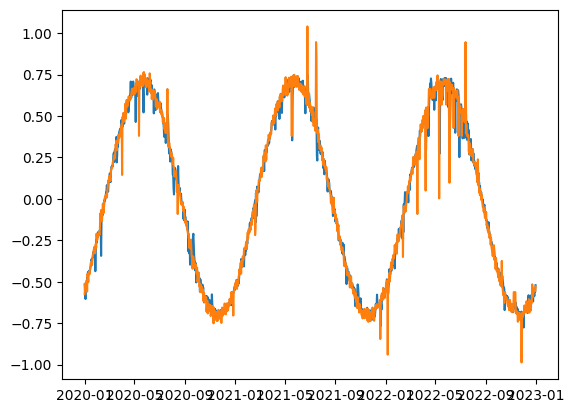

In [58]:
import matplotlib.pyplot as plt
plt.plot(df_prediction['Predicted_temperature'])
plt.plot(y_test['ScaledTemp'])

In [59]:
#test_data(predicted+actual+residual)
data_temp_test = pd.DataFrame({'predicted_temp': df_prediction['Predicted_temperature'], 'actual_temp': y_test['ScaledTemp'], 'residual_temp':(y_test['ScaledTemp'] - df_prediction['Predicted_temperature'])})
data_humidity_test = pd.DataFrame({'predicted_humid': df_prediction['Predicted_humidity'], 'actual_humid': y_test['ScaledHumid'], 'residual_humid':(y_test['ScaledHumid'] - df_prediction['Predicted_humidity'])})
data_pressure_test = pd.DataFrame({'predicted_pressure': df_prediction['Predicted_pressure'], 'actual_pressure': y_test['ScaledPressure'], 'residual_pressure':(y_test['ScaledPressure'] - df_prediction['Predicted_pressure'])})
data_kNN_test=pd.concat([data_temp_test,data_humidity_test,data_pressure_test],axis=1)

In [60]:
nest_samples=1096
le = LabelEncoder()

ground_truth = df_labeled.iloc[:, -1].values
ground_truth_train = ground_truth[:-nest_samples].copy()
ground_truth_test = ground_truth[-nest_samples:].copy()

ground_truth_train = le.fit_transform(ground_truth_train)
ground_truth_test = le.transform(ground_truth_test)

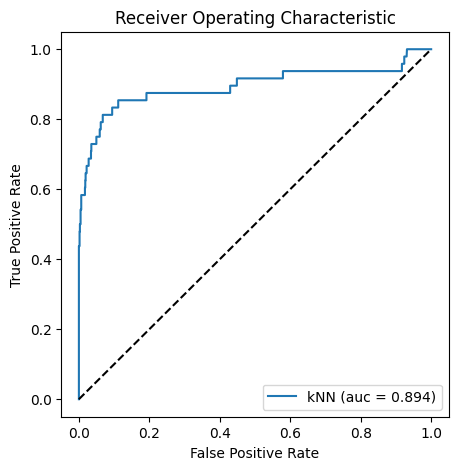


On Test Data:
KNN ROC:0.8944, precision @ rank n:0.6042

Outlier prediction information on Test Data: 1096 {0: 1006, 1: 90}
No of Errors in test set: 66

RMS on Test Set : 0.24539555436517138

MAE on Test Set : 0.060218978102189784


array([[994,  54],
       [ 12,  36]], dtype=int64)

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pyod
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.metrics import roc_auc_score,roc_curve,auc

classifier_name = 'KNN'
# model_knn = KNN()  # with default parameters.
model_knn = KNN()

# Prediction on training data
model_knn.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction = model_knn.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_scores = model_knn.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction = model_knn.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_scores = model_knn.predict_proba(data_kNN_test)[:,1]
# Calculate AUC-ROC score
auc_roc = roc_auc_score(ground_truth_test, test_prediction_scores)
fpr, tpr, thresholds = roc_curve(ground_truth_test, test_prediction_scores)
auc_kNN = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle='-', label='kNN (auc = %0.3f)' % auc_kNN)

#plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], 'k--')  # Random ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print("\nOn Test Data:")
evaluate_print(classifier_name, ground_truth_test, test_prediction_scores)
unique, counts = np.unique(test_prediction, return_counts=True)
print("\nOutlier prediction information on Test Data:", len(data_kNN_test), dict(zip(unique, counts)))
# no of errors in test set
number_of_errors = (test_prediction != ground_truth_test).sum()
print('No of Errors in test set: {}'.format(number_of_errors))
rms = mean_squared_error(ground_truth_test, test_prediction, squared=False)
mae = mean_absolute_error(ground_truth_test, test_prediction)
print('\nRMS on Test Set :',rms)
print('\nMAE on Test Set :',mae)

from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, model_knn.predict(data_kNN_test))

In [62]:
#test_data(predicted+residual)
data_temp_ptest = pd.DataFrame({'predicted_temp': df_prediction['Predicted_temperature'], 'residual_temp':(y_test['ScaledTemp'] - df_prediction['Predicted_temperature'])})
data_humidity_ptest = pd.DataFrame({'predicted_humid': df_prediction['Predicted_humidity'],  'residual_humid':(y_test['ScaledHumid'] - df_prediction['Predicted_humidity'])})
data_pressure_ptest = pd.DataFrame({'predicted_pressure': df_prediction['Predicted_pressure'],  'residual_pressure':(y_test['ScaledPressure'] - df_prediction['Predicted_pressure'])})
data_kNN_ptest=pd.concat([data_temp_ptest,data_humidity_ptest,data_pressure_ptest],axis=1)

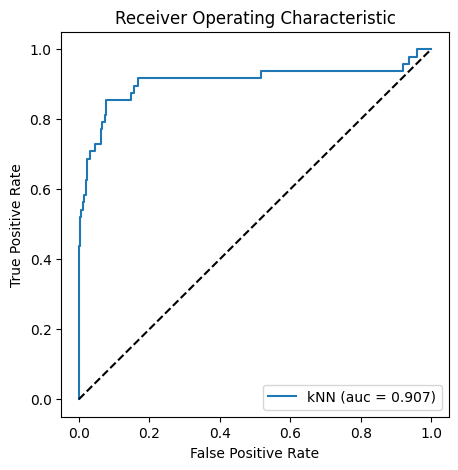


On Test Data:
KNN ROC:0.9073, precision @ rank n:0.5833

Outlier prediction information on Test Data: 1096 {0: 1004, 1: 92}
No of Errors in test set: 70

RMS on Test Set : 0.25272240331772355

MAE on Test Set : 0.06386861313868614


array([[991,  57],
       [ 13,  35]], dtype=int64)

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pyod
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.metrics import roc_auc_score,roc_curve,auc

classifier_name = 'KNN'
# model_knn = KNN()  # with default parameters.
model_knn = KNN()

# Prediction on training data
model_knn.fit(data_kNN_ptest, y=None)  # y is ignored in unsupervised setting.
train_prediction = model_knn.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_scores = model_knn.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction = model_knn.predict(data_kNN_ptest) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_scores = model_knn.predict_proba(data_kNN_ptest)[:,1]
# Calculate AUC-ROC score
auc_roc = roc_auc_score(ground_truth_test, test_prediction_scores)
fpr, tpr, thresholds = roc_curve(ground_truth_test, test_prediction_scores)
auc_kNN = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle='-', label='kNN (auc = %0.3f)' % auc_kNN)

#plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], 'k--')  # Random ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print("\nOn Test Data:")
evaluate_print(classifier_name, ground_truth_test, test_prediction_scores)
unique, counts = np.unique(test_prediction, return_counts=True)
print("\nOutlier prediction information on Test Data:", len(data_kNN_ptest), dict(zip(unique, counts)))
# no of errors in test set
number_of_errors = (test_prediction != ground_truth_test).sum()
print('No of Errors in test set: {}'.format(number_of_errors))
rms = mean_squared_error(ground_truth_test, test_prediction, squared=False)
mae = mean_absolute_error(ground_truth_test, test_prediction)
print('\nRMS on Test Set :',rms)
print('\nMAE on Test Set :',mae)

from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, model_knn.predict(data_kNN_ptest))

In [64]:
#test_data(predicted+actual)
data_temp_ktest = pd.DataFrame({'predicted_temp': df_prediction['Predicted_temperature'], 'actual_temp': y_test['ScaledTemp'], 'residual_temp':(y_test['ScaledTemp'] - df_prediction['Predicted_temperature'])})
data_humidity_ktest = pd.DataFrame({'predicted_humid': df_prediction['Predicted_humidity'], 'actual_humid': y_test['ScaledHumid'], 'residual_humid':(y_test['ScaledHumid'] - df_prediction['Predicted_humidity'])})
data_pressure_ktest = pd.DataFrame({'predicted_pressure': df_prediction['Predicted_pressure'], 'actual_pressure': y_test['ScaledPressure'], 'residual_pressure':(y_test['ScaledPressure'] - df_prediction['Predicted_pressure'])})
data_kNN_ktest=pd.concat([data_temp_ktest,data_humidity_ktest,data_pressure_ktest],axis=1)

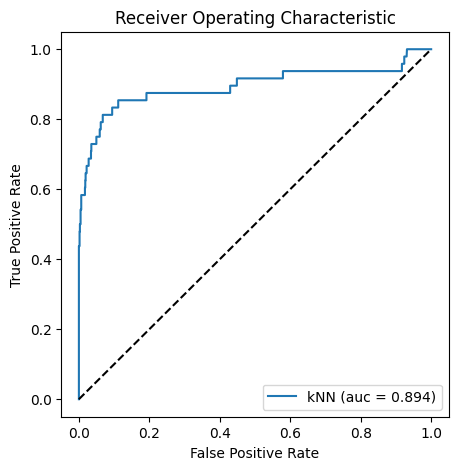


On Test Data:
KNN ROC:0.8944, precision @ rank n:0.6042

Outlier prediction information on Test Data: 1096 {0: 1006, 1: 90}
No of Errors in test set: 66

RMS on Test Set : 0.24539555436517138

MAE on Test Set : 0.060218978102189784


array([[994,  54],
       [ 12,  36]], dtype=int64)

In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pyod
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.metrics import roc_auc_score,roc_curve,auc

classifier_name = 'KNN'
# model_knn = KNN()  # with default parameters.
model_knn = KNN()

# Prediction on training data
model_knn.fit(data_kNN_ktest, y=None)  # y is ignored in unsupervised setting.
train_prediction = model_knn.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_scores = model_knn.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction = model_knn.predict(data_kNN_ktest) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_scores = model_knn.predict_proba(data_kNN_ktest)[:,1]
# Calculate AUC-ROC score
auc_roc = roc_auc_score(ground_truth_test, test_prediction_scores)
fpr, tpr, thresholds = roc_curve(ground_truth_test, test_prediction_scores)
auc_kNN = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle='-', label='kNN (auc = %0.3f)' % auc_kNN)

#plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], 'k--')  # Random ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print("\nOn Test Data:")
evaluate_print(classifier_name, ground_truth_test, test_prediction_scores)
unique, counts = np.unique(test_prediction, return_counts=True)
print("\nOutlier prediction information on Test Data:", len(data_kNN_ktest), dict(zip(unique, counts)))
# no of errors in test set
number_of_errors = (test_prediction != ground_truth_test).sum()
print('No of Errors in test set: {}'.format(number_of_errors))
rms = mean_squared_error(ground_truth_test, test_prediction, squared=False)
mae = mean_absolute_error(ground_truth_test, test_prediction)
print('\nRMS on Test Set :',rms)
print('\nMAE on Test Set :',mae)

from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, model_knn.predict(data_kNN_ktest))

In [66]:
# OBSERVATION: predicted+actual+residual or actual+predicted works best.